In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os, copy
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import time
import math, tqdm
import seaborn as sns
from lib.train import Train
from lib.evaluation import plot_train_val_multiple, plot_train_val
import seaborn as sns
import pandas as pd
from lib.experiment import SYNTHETIC_EXPERIMENTS
import os
from lib.model import MODELS
from lib.train import TrainMORNN
from MTL_OPT.lib.evaluation import plot_best, plot_best_test
torch.set_num_threads(1)

mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^3S3OD.ckpt_best_9


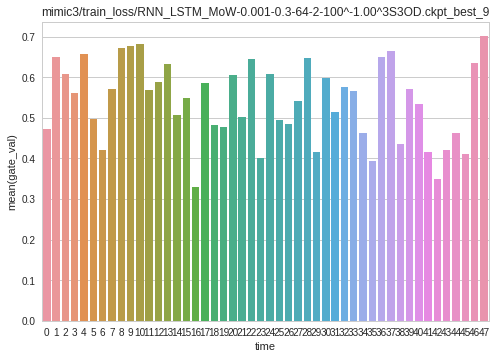

mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^K8LVS.ckpt_best_13


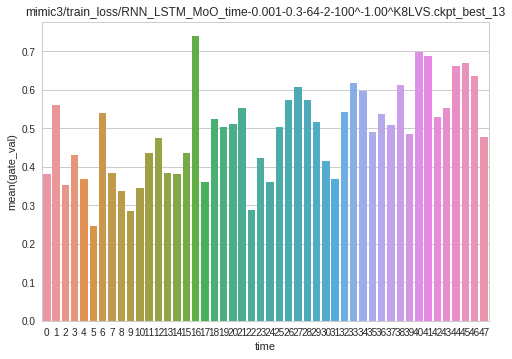

In [156]:
from torch.utils.data import TensorDataset
import tqdm 
import glob, os
from MTL_OPT.lib.evaluation import test_bootstrap, calc_auroc, calc_auprc

def normalize_filename(fn):
    if os.path.exists(fn + ".ckpt_best"):
        return fn + ".ckpt_best"

    epochs = []
    for fn_ in glob.glob(fn + ".ckpt_best_*"):
        epochs.append(int(fn_.split('_')[-1]))
    best_epoch = max(epochs)
    return fn + ".ckpt_best_{}".format(best_epoch)

def load_data(path):
    data = np.load(path)
    x = torch.from_numpy(data['data']).float()
    # x: (N, seq_len, d)                                                                                                                                                             
    y = torch.from_numpy(data['labels'])
    return TensorDataset(x, y)

def coef_case_study(fn):
    # get model
    fn = normalize_filename(fn)
    print(fn)
    embed_size = 76
    dropout, hidden_size, nlayers = fn.split('/')[-1].split('^')[0].split('-')[2:-1]
    hidden_size = int(hidden_size)
    output_size = 2
    nlayers = int(nlayers)
    ndirections = 1
    dropout = float(dropout)
    seq_length = 48
    m = MODELS[fn.split('/')[-1].split('-')[0]](embed_size, hidden_size, output_size, nlayers, ndirections, dropout)
    if hasattr(m, 'set_max_length'):
        m.set_max_length(seq_length)
    elif hasattr(m, 'setKT'):
        m.setKT(2, seq_length)
    m.load_state_dict(torch.load(fn))
    
    # plot trend
    gate = torch.nn.functional.softmax(m.coef, dim=1).detach().cpu().numpy()[:, 0]
    df = pd.DataFrame({'time': np.arange(len(gate)), 'gate_val': gate})
    sns.barplot(x='time', y='gate_val', data=df)
    plt.title(fn)
    plt.show()
    
def report_table(fn, eval_function, K=1000, plot=False):
    # get model
    fn = normalize_filename(fn)
    print(fn)
    embed_size = 76
    dropout, hidden_size, nlayers = fn.split('/')[-1].split('^')[0].split('-')[2:-1]
    hidden_size = int(hidden_size)
    output_size = 2
    nlayers = int(nlayers)
    ndirections = 1
    dropout = float(dropout)
    seq_length = 48
    m = MODELS[fn.split('/')[-1].split('-')[0]](embed_size, hidden_size, output_size, nlayers, ndirections, dropout)
    if hasattr(m, 'set_max_length'):
        m.set_max_length(seq_length)
    elif hasattr(m, 'setKT'):
        m.setKT(2, seq_length)
    m.load_state_dict(torch.load(fn))

    # get data
    # datapath = "{}/jeeheh_IHMnpz".format(os.environ['mimic3path']) 
    datapath = "mimic3/jeeheh_IHMnpz"
    test_dataset = load_data('{}/IHM_test.npz'.format(datapath))
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=100,
                                              shuffle=False)

    # test
    res = test_bootstrap(m, test_loader, eval_function, K=K)
    if plot:
        sns.distplot(res)
        plt.show()
        
    return np.percentile(res, [2.5, 50, 97.5])
    
fn = 'mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^3S3OD'
coef_case_study(fn)

fn = 'mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^K8LVS'
coef_case_study(fn)

#res = report_table(fn, calc_auprc, K=10000)
#print("(" + ", ".join(map(lambda x: "{:.4f}".format(x), res)) + ")")

# MIMIC3

RNN_LSTM_MoO_time test: 0.817 val: -0.823 fn:mimic3/train_loss_0.1/RNN_LSTM_MoO_time-0.001-0.3-32-1-100^-1.00^U48MC.train_losses
RNN_LSTM test: 0.812 val: -0.818 fn:mimic3/train_loss_0.1/RNN_LSTM-0.001-0.3-32-2-100^-1.00^9073R.train_losses
RNN_ILSTM test: 0.810 val: -0.818 fn:mimic3/train_loss_0.1/RNN_ILSTM-0.001-0.3-64-1-100^-1.00^FO0E7.train_losses
RNN_LSTM_MoO test: 0.818 val: -0.823 fn:mimic3/train_loss_0.1/RNN_LSTM_MoO-0.001-0.3-64-1-100^-1.00^CHYMR.train_losses
RNN_LSTM_MoW test: 0.817 val: -0.820 fn:mimic3/train_loss_0.1/RNN_LSTM_MoW-0.001-0.3-32-1-100^-1.00^RK848.train_losses


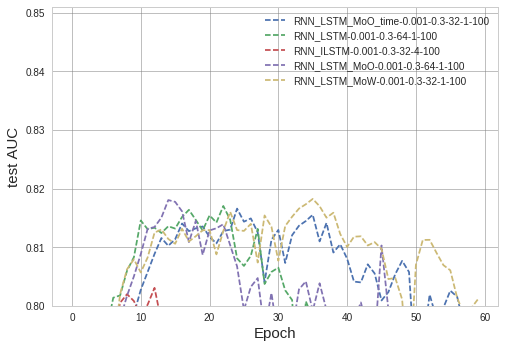

RNN_LSTM_MoO_time test: 0.851 val: -0.851 fn:mimic3/train_loss_0.5/RNN_LSTM_MoO_time-0.001-0.3-64-1-100^-1.00^1L5HS.train_losses
RNN_LSTM test: 0.850 val: -0.843 fn:mimic3/train_loss_0.5/RNN_LSTM-0.001-0.3-64-1-100^-1.00^SHIRW.train_losses
RNN_ILSTM test: 0.835 val: -0.837 fn:mimic3/train_loss_0.5/RNN_ILSTM-0.001-0.3-64-1-100^-1.00^0NT5W.train_losses
RNN_LSTM_MoO test: 0.847 val: -0.848 fn:mimic3/train_loss_0.5/RNN_LSTM_MoO-0.001-0.3-32-2-100^-1.00^QIJIG.train_losses
RNN_LSTM_MoW test: 0.847 val: -0.849 fn:mimic3/train_loss_0.5/RNN_LSTM_MoW-0.001-0.3-16-1-100^-1.00^KLL1I.train_losses


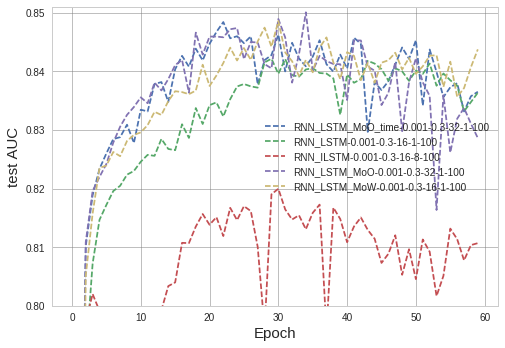

In [145]:
plot_best_test('mimic3/train_loss_0.1/*.train_losses', ylabel='AUC', ylim=[0.8, 0.851], q_low=25, q_high=75)
plot_best_test('mimic3/train_loss_0.5/*.train_losses', ylabel='AUC', ylim=[0.8, 0.851], q_low=25, q_high=75)

#plot_best('mimic3/train_loss_0.1/*.train_errors')
#plot_best('mimic3/train_loss/*.train_errors')
#plot_best('mimic3/train_loss/*.val_errors')

RNN_LSTM_MoO_time test: 0.813 val: -0.966 fn:mimic3/train_loss_1.0_test/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^TGXUF.train_losses
RNN_LSTM test: 0.853 val: -0.902 fn:mimic3/train_loss_1.0_test/RNN_LSTM-0.001-0.3-16-1-100^-1.00^5Q51Q.train_losses
RNN_ILSTM test: 0.729 val: -0.999 fn:mimic3/train_loss_1.0_test/RNN_ILSTM-0.001-0.3-32-2-100^-1.00^77K9X.train_losses
RNN_LSTM_MoO test: 0.835 val: -0.945 fn:mimic3/train_loss_1.0_test/RNN_LSTM_MoO-0.001-0.3-32-4-100^-1.00^09T5S.train_losses
RNN_LSTM_MoW test: 0.833 val: -0.953 fn:mimic3/train_loss_1.0_test/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^0JHRC.train_losses


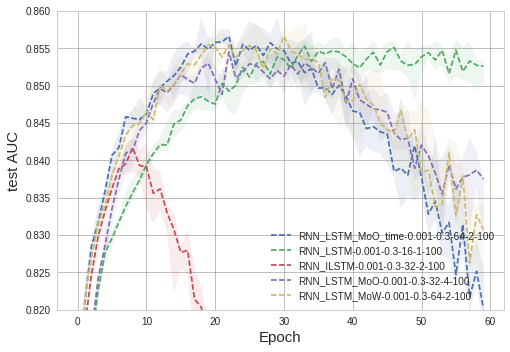

In [159]:
plot_best_test('mimic3/train_loss_1.0_test/*.train_losses', ylabel='AUC', ylim=[0.82, 0.86], q_low=25, q_high=75)

RNN_LSTM_MoO_time test: 0.856 val: -0.860 fn:mimic3/train_loss4_1.0/RNN_LSTM_MoO_time-0.001-0.3-64-1-100^-1.00^VY96J.train_losses
RNN_LSTM test: 0.856 val: -0.859 fn:mimic3/train_loss4_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^L4A7U.train_losses
RNN_ILSTM test: 0.841 val: -0.852 fn:mimic3/train_loss4_1.0/RNN_ILSTM-0.001-0.3-32-1-100^-1.00^7EECY.train_losses
RNN_LSTM_MoO test: 0.852 val: -0.863 fn:mimic3/train_loss4_1.0/RNN_LSTM_MoO-0.001-0.3-64-1-100^-1.00^7QG28.train_losses
RNN_LSTM_MoW test: 0.854 val: -0.859 fn:mimic3/train_loss4_1.0/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^BLKV9.train_losses


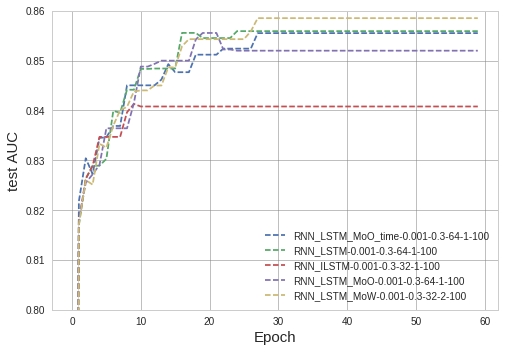

RNN_LSTM_MoO_time test: 0.858 val: -0.862 fn:mimic3/train_loss3_1.0/RNN_LSTM_MoO_time-0.001-0.3-64-1-100^-1.00^HG22B.train_losses
RNN_LSTM test: 0.855 val: -0.857 fn:mimic3/train_loss3_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^863WT.train_losses
RNN_ILSTM test: 0.838 val: -0.848 fn:mimic3/train_loss3_1.0/RNN_ILSTM-0.001-0.3-64-4-100^-1.00^316OI.train_losses
RNN_LSTM_MoO test: 0.854 val: -0.858 fn:mimic3/train_loss3_1.0/RNN_LSTM_MoO-0.001-0.3-16-1-100^-1.00^ZQ83T.train_losses
RNN_LSTM_MoW test: 0.852 val: -0.860 fn:mimic3/train_loss3_1.0/RNN_LSTM_MoW-0.001-0.3-64-1-100^-1.00^JL3HX.train_losses


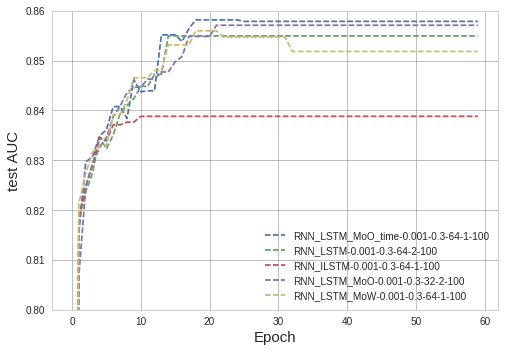

RNN_LSTM_MoO_time test: 0.855 val: -0.860 fn:mimic3/train_loss2_1.0/RNN_LSTM_MoO_time-0.001-0.3-32-1-100^-1.00^E6QRY.train_losses
RNN_LSTM test: 0.854 val: -0.857 fn:mimic3/train_loss2_1.0/RNN_LSTM-0.001-0.3-32-1-100^-1.00^8A5Q8.train_losses
RNN_ILSTM test: 0.833 val: -0.848 fn:mimic3/train_loss2_1.0/RNN_ILSTM-0.001-0.3-64-1-100^-1.00^JYT15.train_losses
RNN_LSTM_MoO test: 0.855 val: -0.858 fn:mimic3/train_loss2_1.0/RNN_LSTM_MoO-0.001-0.3-64-2-100^-1.00^8S98N.train_losses
RNN_LSTM_MoW test: 0.849 val: -0.862 fn:mimic3/train_loss2_1.0/RNN_LSTM_MoW-0.001-0.3-32-4-100^-1.00^JLPD9.train_losses


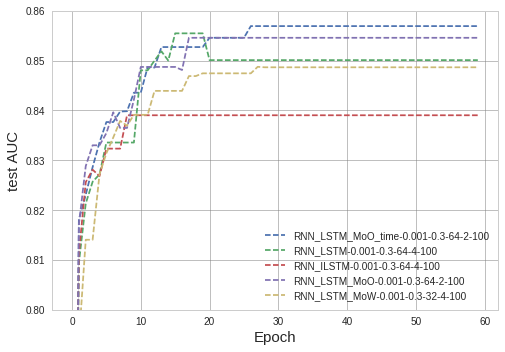

RNN_LSTM_MoO_time test: 0.858 val: -0.858 fn:mimic3/train_loss_1.0/RNN_LSTM_MoO_time-0.001-0.3-64-1-100^-1.00^F8UTT.train_losses
RNN_LSTM test: 0.854 val: -0.857 fn:mimic3/train_loss_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^HYRIH.train_losses
RNN_ILSTM test: 0.836 val: -0.847 fn:mimic3/train_loss_1.0/RNN_ILSTM-0.001-0.3-64-1-100^-1.00^21LGE.train_losses
RNN_LSTM_MoO test: 0.859 val: -0.860 fn:mimic3/train_loss_1.0/RNN_LSTM_MoO-0.001-0.3-64-1-100^-1.00^NETBZ.train_losses
RNN_LSTM_MoW test: 0.856 val: -0.860 fn:mimic3/train_loss_1.0/RNN_LSTM_MoW-0.001-0.3-64-1-100^-1.00^8H168.train_losses


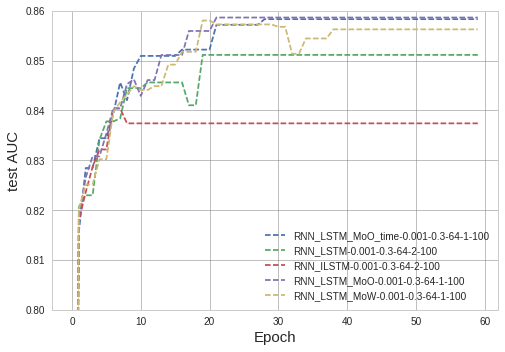

RNN_LSTM_MoO_time test: 0.852 val: -0.860 fn:mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^K8LVS.train_losses
RNN_LSTM test: 0.852 val: -0.856 fn:mimic3/train_loss/RNN_LSTM-0.001-0.3-16-1-100^-1.00^2O8NM.train_losses
RNN_ILSTM test: 0.838 val: -0.850 fn:mimic3/train_loss/RNN_ILSTM-0.001-0.3-32-2-100^-1.00^FXNAZ.train_losses
RNN_LSTM_MoO test: 0.855 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoO-0.001-0.3-32-4-100^-1.00^6XU80.train_losses
RNN_LSTM_MoW test: 0.858 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^3S3OD.train_losses


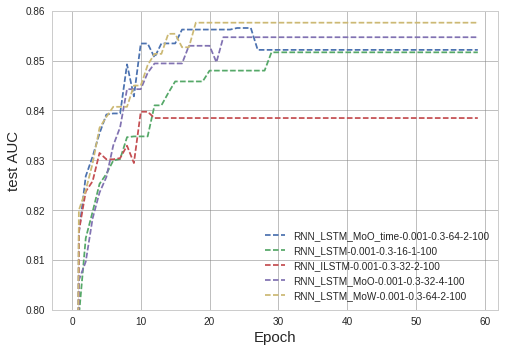

In [244]:
plot_best_test('mimic3/train_loss4_1.0/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], 
               q_low=25, q_high=75, early_stop=True, early_stop_patience=10)
plot_best_test('mimic3/train_loss3_1.0/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75,
                early_stop=True, early_stop_patience=10)
plot_best_test('mimic3/train_loss2_1.0/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75,
               early_stop=True, early_stop_patience=10)
plot_best_test('mimic3/train_loss_1.0/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75,
                early_stop=True, early_stop_patience=10)
plot_best_test('mimic3/train_loss/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75,
                early_stop=True, early_stop_patience=10)

In [213]:
# lstm: mimic3/train_loss/RNN_LSTM-0.001-0.3-16-1-100^-1.00^2O8NM
# lstm-mow: mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^3S3OD
# lstm-moo: mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^K8LVS
# lstm-ind: mimic3/train_loss/RNN_ILSTM-0.001-0.3-32-2-100^-1.00^FXNAZ
fn = 'mimic3/train_loss4_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^L4A7U'
res = report_table(fn, calc_auroc, K=10000)
print("auroc", "(" + ", ".join(map(lambda x: "{:.4f}".format(x), res)) + ")")

res = report_table(fn, calc_auprc, K=10000)
print("auprc", "(" + ", ".join(map(lambda x: "{:.4f}".format(x), res)) + ")")


mimic3/train_loss4_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^L4A7U.ckpt_best


/home/jiaxuan/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
  1%|          | 67/10000 [00:00<00:14, 664.17it/s]

done getting prediction


100%|██████████| 10000/10000 [00:15<00:00, 640.29it/s]


auroc (0.8358, 0.8562, 0.8748)
mimic3/train_loss4_1.0/RNN_LSTM-0.001-0.3-64-1-100^-1.00^L4A7U.ckpt_best


  0%|          | 47/10000 [00:00<00:21, 464.53it/s]

done getting prediction


100%|██████████| 10000/10000 [00:14<00:00, 675.03it/s]

auprc (0.4438, 0.4967, 0.5482)


CrossAdaBound test: 0.846 val: -0.855 fn:mimic3/train_loss_opt/CrossAdaBound-0.001-0.3-32-2-100^-1.00^UE2DH.train_losses
AdaBound test: 0.849 val: -0.856 fn:mimic3/train_loss_opt/AdaBound-0.001-0.3-32-2-100^-1.00^Y4290.train_losses
Swats test: 0.856 val: -0.856 fn:mimic3/train_loss_opt/Swats-0.001-0.3-32-2-100^-1.00^Z5I1V.train_losses
CrossBound test: 0.855 val: -0.857 fn:mimic3/train_loss_opt/CrossBound-0.01-0.3-32-2-100^-1.00^5WMV0.train_losses


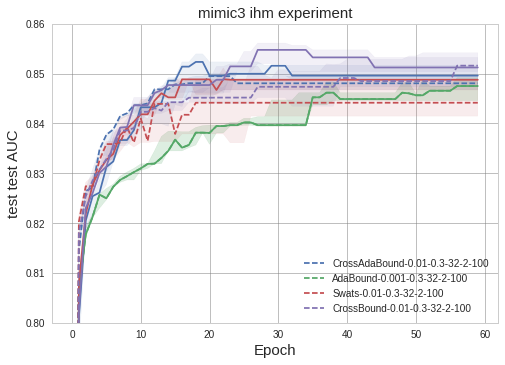

CrossAdaBound: -1.00% (0.00) 5 runs
AdaBound: -1.00% (0.00) 5 runs
Swats: -1.00% (0.00) 5 runs
CrossBound: -1.00% (0.00) 5 runs


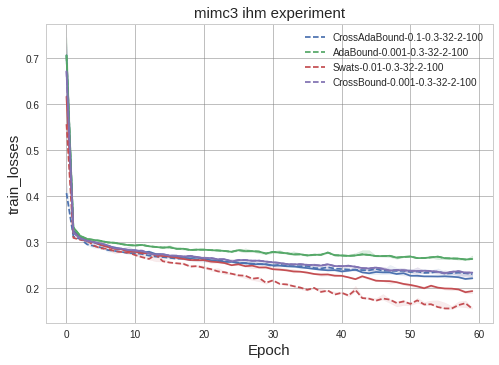

In [252]:
default_setting = {'AdaBound': '0.001-0.3-32-2-100',
 'Adam': '0.001-0.3-32-2-100',
 'CrossAdaBound': '0.001-0.3-32-2-100',
 'CrossBound': '0.001-0.3-32-2-100',
 'Diff': '0.001-0.3-32-2-100',
 'SGD': '0.1-0.3-32-2-100',
 'Swats': '0.001-0.3-32-2-100'}

# methods = ['Diff', 'Adam', 'SGD'] # which one to use
methods = ['CrossBound', 'AdaBound', 'Swats', 'CrossAdaBound'] # when to switch
# methods = ['Diff', 'Adam', 'CrossBound'] # best

plot_best_test('mimic3/train_loss_opt/*train_losses', 
               title='mimic3 ihm experiment', smooth_window=1, ylim=[0.8, 0.86], q_low=25, q_high=75,
               methods=methods, start=0, default_setting=default_setting, ylabel='test AUC',
               early_stop=True, early_stop_patience=None)

plot_best('mimic3/train_loss_opt/*train_losses', 
               title='mimc3 ihm experiment', smooth_window=1, ylim=None, methods=methods,
               start=0, default_setting=default_setting)

#plot_tracker(joblib.load('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/language_model_wiki/train_loss/CrossAdaBound-0.001^-1.00^8V3QC.opt_track'), 0)
#plot_tracker(joblib.load('/data2/jiaxuan/2019/pytorch_tutorial_fork/tutorials/02-intermediate/language_model_wiki/train_loss/Swats-0.001^-1.00^JW23S.opt_track'), 0)

# Early stopping evaluation

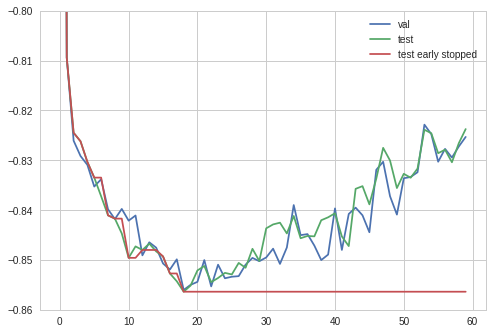

In [231]:
from sklearn.externals import joblib
fn = 'mimic3/train_loss_opt/Swats-0.001-0.3-32-2-100^-1.00^Z5I1V'
val_curve = np.array(joblib.load(fn + ".val_errors"))
test_curve = - np.array(joblib.load(fn + ".test_errors"))

def plot_curve(curve, label=None):
    plt.plot(curve, label=label)
    plt.ylim(-0.86, -0.8)

def early_stop_curve(curve, patience=None):
    # return the index of the early stopping criteria if I were to stop there
    patience = patience or len(curve) # default to just search the minimum
    index_list = []
    min_sofar, min_index = curve[0], 0
    for i, v in enumerate(curve):
        if v <= min_sofar and (i - min_index) <= patience:
            min_sofar, min_index = v, i
        index_list.append(min_index)
    return np.array(index_list)

plot_curve(val_curve, label='val')
plot_curve(test_curve, label='test')
index_list = early_stop_curve(val_curve, patience=None)
#plot_curve(val_curve[index_list], label='val early stopped')
plot_curve(test_curve[index_list], label='test early stopped')
plt.legend()

# old

RNN_ILSTM test: 0.838 val: -0.850 fn:mimic3/train_loss/RNN_ILSTM-0.001-0.3-32-2-100^-1.00^FXNAZ.train_losses
RNN_LSTM test: 0.852 val: -0.856 fn:mimic3/train_loss/RNN_LSTM-0.001-0.3-16-1-100^-1.00^2O8NM.train_losses
RNN_LSTM_MoO test: 0.855 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoO-0.001-0.3-32-4-100^-1.00^6XU80.train_losses
RNN_LSTM_MoW test: 0.858 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-64-2-100^-1.00^3S3OD.train_losses
RNN_LSTM_MoO_time test: 0.852 val: -0.860 fn:mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^K8LVS.train_losses


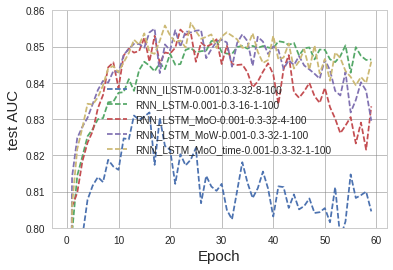

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


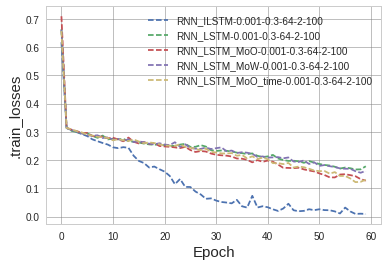

In [191]:
plot_best_test('mimic3/train_loss/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75)
plot_best('mimic3/train_loss/*.train_losses')
#plot_best('mimic3/train_loss/*.train_errors')
#plot_best('mimic3/train_loss/*.val_errors')

RNN_ILSTM test: 0.836 val: -0.848 fn:mimic3/train_loss/RNN_ILSTM-0.001-0.3-32-1-100^-1.00^B2LNV.train_losses
RNN_LSTM_MoO test: 0.849 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoO-0.001-0.3-32-2-100^-1.00^1WNT9.train_losses
RNN_LSTM test: 0.857 val: -0.855 fn:mimic3/train_loss/RNN_LSTM-0.001-0.3-64-2-100^-1.00^TSVPB.train_losses
RNN_LSTM_MoW test: 0.856 val: -0.859 fn:mimic3/train_loss/RNN_LSTM_MoW-0.001-0.3-32-1-100^-1.00^B3OPK.train_losses
RNN_LSTM_MoO_time test: 0.855 val: -0.858 fn:mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0.3-64-2-100^-1.00^EAAYE.train_losses


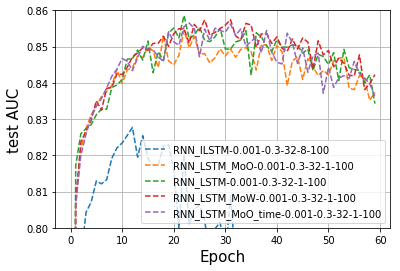

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


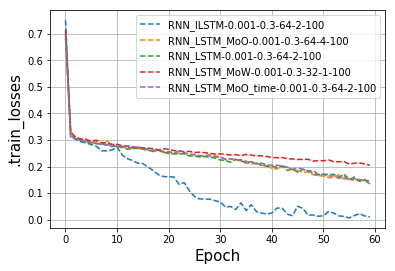

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


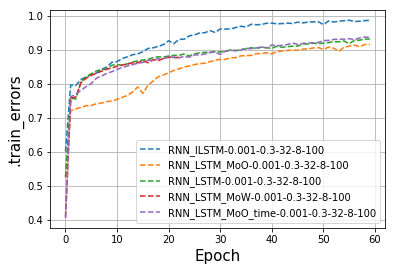

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


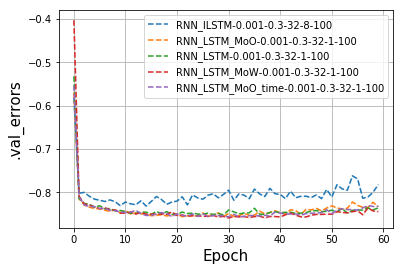

In [265]:
plot_best_test('mimic3/train_loss/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75)
plot_best('mimic3/train_loss/*.train_losses')
plot_best('mimic3/train_loss/*.train_errors')
plot_best('mimic3/train_loss/*.val_errors')

RNN_ILSTM test: 0.834 mimic3/train_loss/RNN_ILSTM-0.001-0-16-2-100^-1.00^K6R2Y.train_losses
RNN_LSTM_MoO test: 0.847 mimic3/train_loss/RNN_LSTM_MoO-0.001-0-16^-1.00^X1ESU.train_losses
RNN_LSTM test: 0.842 mimic3/train_loss/RNN_LSTM-0.001^-1.00^2RYW1.train_losses
RNN_LSTM_MoW test: 0.854 mimic3/train_loss/RNN_LSTM_MoW-0.001^-1.00^YTUII.train_losses
RNN_LSTM_MoO_time test: 0.848 mimic3/train_loss/RNN_LSTM_MoO_time-0.001-0-16^-1.00^F9HOY.train_losses


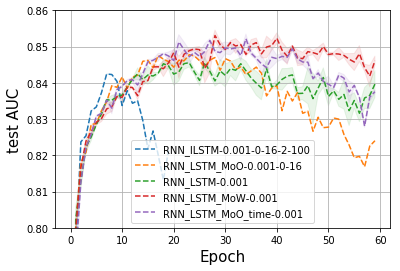

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 2 runs
RNN_LSTM: -1.00% (0.00) 2 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


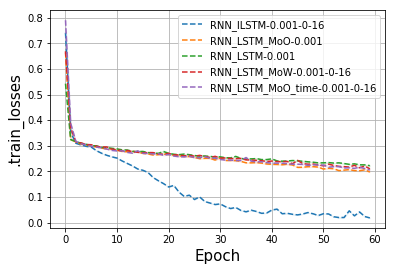

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoW: -1.00% (0.00) 1 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 1 runs


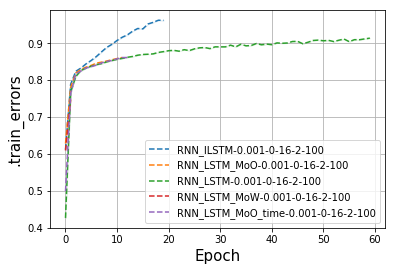

RNN_ILSTM: -1.00% (0.00) 1 runs
RNN_LSTM_MoO: -1.00% (0.00) 1 runs
RNN_LSTM: -1.00% (0.00) 2 runs
RNN_LSTM_MoW: -1.00% (0.00) 2 runs
RNN_LSTM_MoO_time: -1.00% (0.00) 2 runs


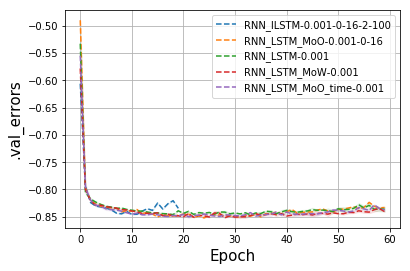

In [177]:
plot_best_test('mimic3/train_loss/*.train_losses', ylabel='AUC', ylim=[0.8, 0.86], q_low=25, q_high=75)
plot_best('mimic3/train_loss/*.train_losses')
plot_best('mimic3/train_loss/*.train_errors')
plot_best('mimic3/train_loss/*.val_errors')

# case study on MoW vs. (MoO and MoOt)

Observation: MoW better uses partial gate (not either 0 or 1)

## MoW

=> loading checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_mow_2_best.pth.tar' (iteration 10001)


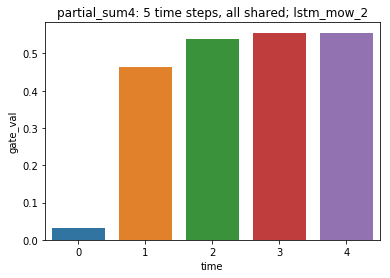

=> loading checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_mow_2_best.pth.tar' (iteration 7001)


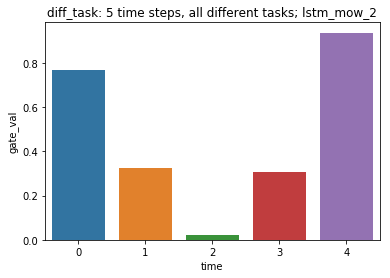

=> loading checkpoint 'mo_models_2layers/scarce_10000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_10000/0/lstm_mow_2_best.pth.tar' (iteration 9001)


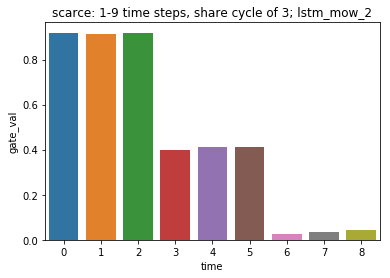

=> loading checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_mow_2_best.pth.tar' (iteration 10001)


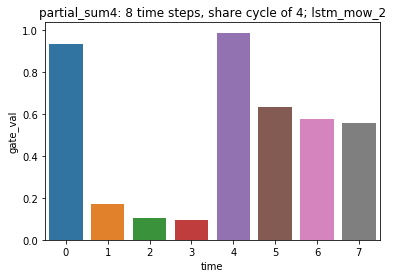

In [205]:
def MoW_case_study(exp_name, run_number=0, n_samples=10000):
    model_name = 'lstm_mow_2'

    # get the dataset
    exp = SYNTHETIC_EXPERIMENTS[exp_name]
    #savename_tr = os.path.join('sequence_data/{}_{}'.format(exp_name, n_samples), 'train.pkl')
    #data = exp.load_data(savename_tr)

    # get model
    net = MODELS['RNN_LSTM_MoW'](784, 30, 10, num_layers=2)
    net.setKT(2, exp.max_length)
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.NLLLoss()
    trainer = TrainMORNN(net, optimizer, criterion, data)
    trainer.load_checkpoint('mo_models_2layers/{}_{}/{}/{}_best.pth.tar'.format(exp_name, 
                                                                                n_samples, 
                                                                                run_number,
                                                                                model_name))

    # plot trend
    gate = torch.nn.functional.softmax(net.coef, dim=1).detach().cpu().numpy()[:, 0]
    df = pd.DataFrame({'time': np.arange(len(gate)), 'gate_val': gate})
    sns.barplot(x='time', y='gate_val', data=df)
    plt.title("{}; {}".format(exp.describe(), model_name))
    plt.show()
    
MoW_case_study('partial_sum4', run_number=0, n_samples=10000)
MoW_case_study('diff_task', run_number=0, n_samples=10000)
MoW_case_study('scarce', run_number=0, n_samples=10000)
MoW_case_study('partial_sum_share', run_number=0, n_samples=10000)

=> loading checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_mow_2_best.pth.tar' (iteration 7001)


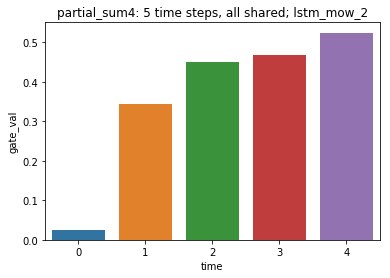

=> loading checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_mow_2_best.pth.tar' (iteration 10001)


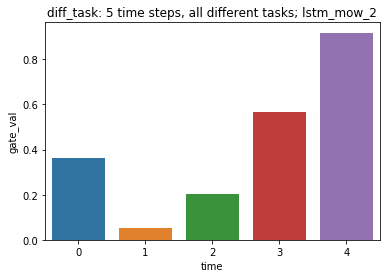

=> loading checkpoint 'mo_models_2layers/scarce_1000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_1000/0/lstm_mow_2_best.pth.tar' (iteration 9001)


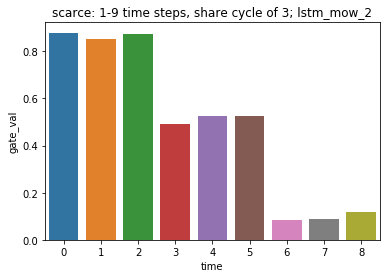

=> loading checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_mow_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_mow_2_best.pth.tar' (iteration 2001)


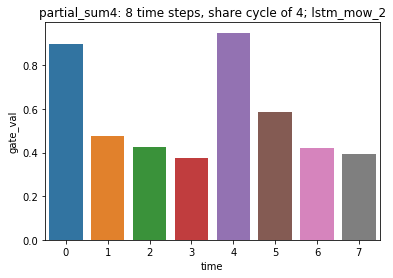

In [206]:
MoW_case_study('partial_sum4', run_number=0, n_samples=1000)
MoW_case_study('diff_task', run_number=0, n_samples=1000)
MoW_case_study('scarce', run_number=0, n_samples=1000)
MoW_case_study('partial_sum_share', run_number=0, n_samples=1000)

## MoO time

=> loading checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_moot_2_best.pth.tar' (iteration 9001)


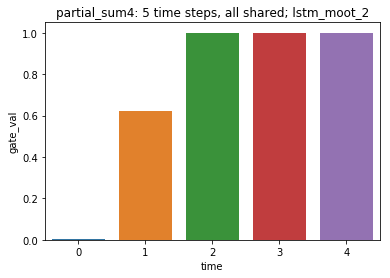

=> loading checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_moot_2_best.pth.tar' (iteration 7001)


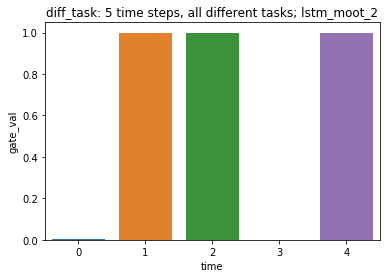

=> loading checkpoint 'mo_models_2layers/scarce_10000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_10000/0/lstm_moot_2_best.pth.tar' (iteration 9001)


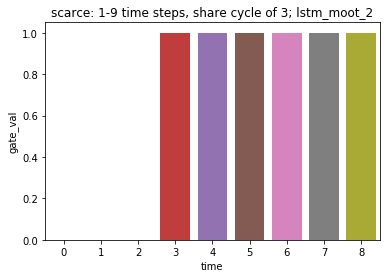

=> loading checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_moot_2_best.pth.tar' (iteration 10001)


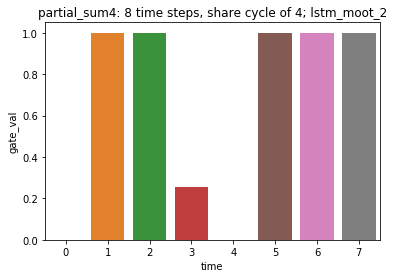

In [204]:
def MoO_time_case_study(exp_name, run_number=0, n_samples=10000):
    model_name = 'lstm_moot_2'

    # get the dataset
    exp = SYNTHETIC_EXPERIMENTS[exp_name]
    #savename_tr = os.path.join('sequence_data/{}_{}'.format(exp_name, n_samples), 'train.pkl')
    #data = exp.load_data(savename_tr)

    # get model
    net = MODELS['RNN_LSTM_MoO_time'](784, 30, 10, num_layers=2)
    net.setKT(2, exp.max_length)
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.NLLLoss()
    trainer = TrainMORNN(net, optimizer, criterion, data)
    trainer.load_checkpoint('mo_models_2layers/{}_{}/{}/{}_best.pth.tar'.format(exp_name, 
                                                                                n_samples, 
                                                                                run_number,
                                                                                model_name))

    # plot trend
    gate = torch.nn.functional.softmax(net.coef, dim=1).detach().cpu().numpy()[:, 0]
    df = pd.DataFrame({'time': np.arange(len(gate)), 'gate_val': gate})
    sns.barplot(x='time', y='gate_val', data=df)
    plt.title("{}; {}".format(exp.describe(), model_name))
    plt.show()
    
MoO_time_case_study('partial_sum4', run_number=0, n_samples=10000)
MoO_time_case_study('diff_task', run_number=0, n_samples=10000)
MoO_time_case_study('scarce', run_number=0, n_samples=10000)
MoO_time_case_study('partial_sum_share', run_number=0, n_samples=10000)

=> loading checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_moot_2_best.pth.tar' (iteration 2001)


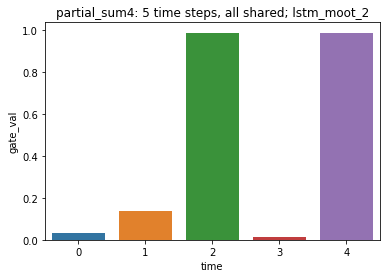

=> loading checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_moot_2_best.pth.tar' (iteration 2001)


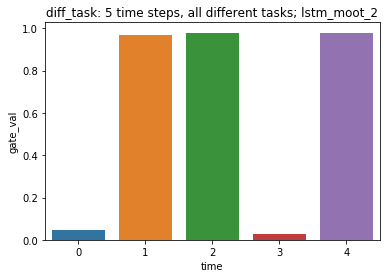

=> loading checkpoint 'mo_models_2layers/scarce_1000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_1000/0/lstm_moot_2_best.pth.tar' (iteration 2001)


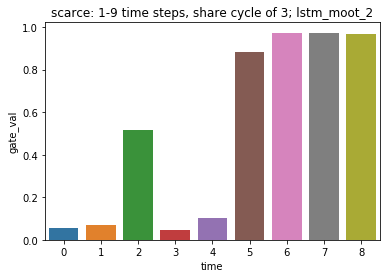

=> loading checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_moot_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_moot_2_best.pth.tar' (iteration 2001)


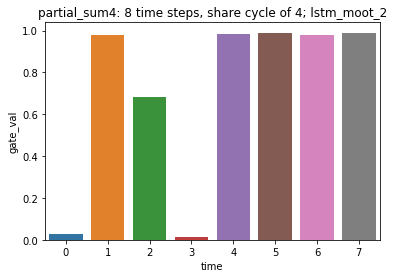

In [207]:
MoO_time_case_study('partial_sum4', run_number=0, n_samples=1000)
MoO_time_case_study('diff_task', run_number=0, n_samples=1000)
MoO_time_case_study('scarce', run_number=0, n_samples=1000)
MoO_time_case_study('partial_sum_share', run_number=0, n_samples=1000)

## MoO

==>load data sequence_data/partial_sum4_10000/test.pkl


  3%|▎         | 8/312 [00:00<00:03, 76.29it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_10000/0/lstm_moo_2_best.pth.tar' (iteration 10001)


100%|██████████| 312/312 [00:04<00:00, 62.51it/s]


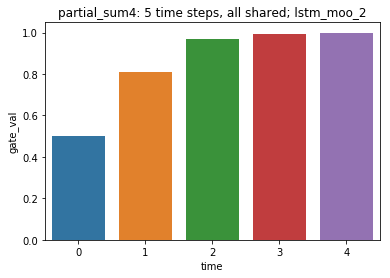

==>load data sequence_data/diff_task_10000/test.pkl


  3%|▎         | 9/312 [00:00<00:03, 80.49it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_10000/0/lstm_moo_2_best.pth.tar' (iteration 9001)


100%|██████████| 312/312 [00:04<00:00, 71.79it/s]


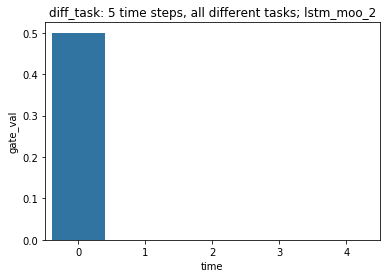

==>load data sequence_data/scarce_10000/test.pkl


  2%|▏         | 5/312 [00:00<00:06, 44.95it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/scarce_10000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_10000/0/lstm_moo_2_best.pth.tar' (iteration 8001)


100%|██████████| 312/312 [00:07<00:00, 41.69it/s]


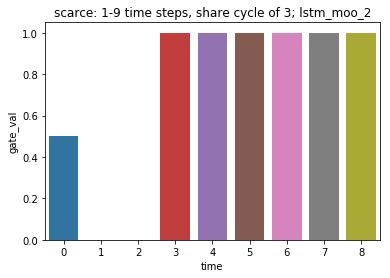

==>load data sequence_data/partial_sum_share_10000/test.pkl


  2%|▏         | 5/312 [00:00<00:06, 46.07it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_10000/0/lstm_moo_2_best.pth.tar' (iteration 10001)


100%|██████████| 312/312 [00:11<00:00, 27.78it/s]


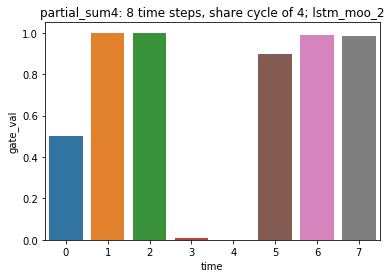

In [203]:
def MoO_case_study(exp_name, run_number=0, n_samples=10000):
    model_name = 'lstm_moo_2'
    
    # get the dataset
    exp = SYNTHETIC_EXPERIMENTS[exp_name]
    savename_tr = os.path.join('sequence_data/{}_{}'.format(exp_name, n_samples), 'test.pkl')
    data = exp.load_data(savename_tr)

    # get model
    net = MODELS['RNN_LSTM_MoO'](784, 30, 10, num_layers=2)
    net.setKT(2, exp.max_length)
    optimizer = torch.optim.Adam(net.parameters())
    criterion = nn.NLLLoss()
    trainer = TrainMORNN(net, optimizer, criterion, data)
    trainer.load_checkpoint('mo_models_2layers/{}_{}/{}/{}_best.pth.tar'.format(exp_name, 
                                                                                n_samples, 
                                                                                run_number,
                                                                                model_name))
    
    # run a few examples from the dataset; collect mean coefficient used for each time step
    net.eval()
    batch_size = 32
    niters = int(len(data) / batch_size)
    
    gate = np.zeros(exp.max_length)
    count_gate = np.zeros(exp.max_length)
    for _ in tqdm.tqdm(range(niters)):
        x, y, length = data.next_batch(batch_size)
        hidden = net.initHidden(batch_size)
        o, hidden = net(x, hidden, length)
        for t, coef in enumerate(net.last_combine_weights):
            for i, gate0_use in enumerate(coef.cpu().detach().numpy()[:,0]):
                if t < length[i]: # length masking
                    gate[t] += gate0_use
                    count_gate[t] += 1
            
    gate = gate / count_gate
    
    # plot trend
    df = pd.DataFrame({'time': np.arange(len(gate)), 'gate_val': gate})
    sns.barplot(x='time', y='gate_val', data=df)
    plt.title("{}; {}".format(exp.describe(), model_name))
    plt.show()

MoO_case_study('partial_sum4', run_number=0, n_samples=10000)
MoO_case_study('diff_task', run_number=0, n_samples=10000)
MoO_case_study('scarce', run_number=0, n_samples=10000)
MoO_case_study('partial_sum_share', run_number=0, n_samples=10000)

==>load data sequence_data/partial_sum4_1000/test.pkl


  2%|▏         | 5/312 [00:00<00:06, 48.39it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum4_1000/0/lstm_moo_2_best.pth.tar' (iteration 9001)


100%|██████████| 312/312 [00:04<00:00, 67.78it/s]


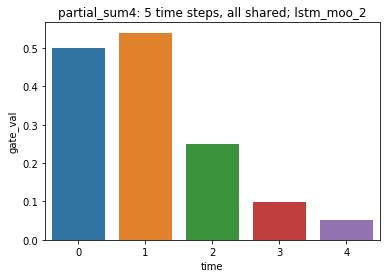

==>load data sequence_data/diff_task_1000/test.pkl


  3%|▎         | 8/312 [00:00<00:03, 78.22it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/diff_task_1000/0/lstm_moo_2_best.pth.tar' (iteration 9001)


100%|██████████| 312/312 [00:05<00:00, 62.39it/s]


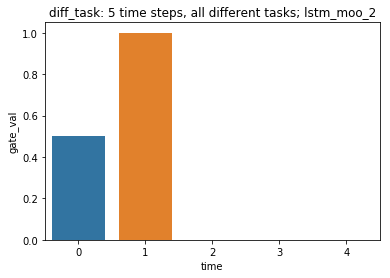

==>load data sequence_data/scarce_1000/test.pkl


  2%|▏         | 5/312 [00:00<00:07, 43.51it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/scarce_1000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/scarce_1000/0/lstm_moo_2_best.pth.tar' (iteration 2001)


100%|██████████| 312/312 [00:08<00:00, 34.83it/s]


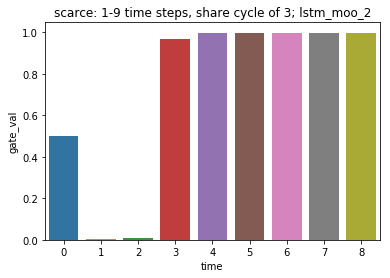

==>load data sequence_data/partial_sum_share_1000/test.pkl


  2%|▏         | 6/312 [00:00<00:06, 50.55it/s]

==>load data of size 10000 done
=> loading checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_moo_2_best.pth.tar'
=> loaded checkpoint 'mo_models_2layers/partial_sum_share_1000/0/lstm_moo_2_best.pth.tar' (iteration 6001)


100%|██████████| 312/312 [00:08<00:00, 38.56it/s]


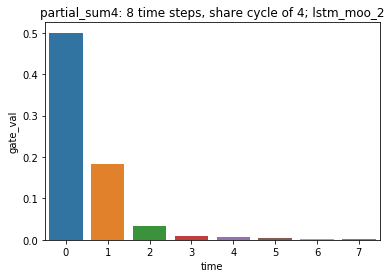

In [208]:
MoO_case_study('partial_sum4', run_number=0, n_samples=1000)
MoO_case_study('diff_task', run_number=0, n_samples=1000)
MoO_case_study('scarce', run_number=0, n_samples=1000)
MoO_case_study('partial_sum_share', run_number=0, n_samples=1000)

# all results

 14%|█▍        | 1/7 [00:00<00:01,  5.19it/s]

training size 1000


100%|██████████| 7/7 [00:01<00:00,  4.65it/s]


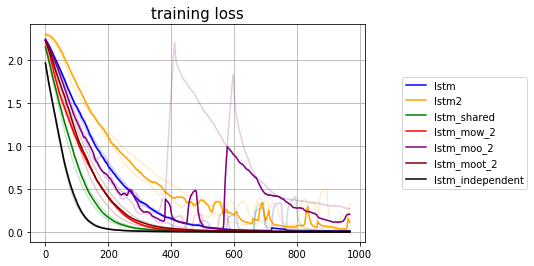

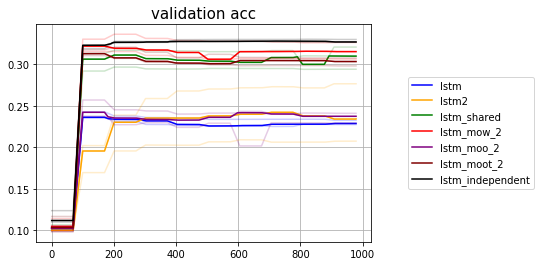

 14%|█▍        | 1/7 [00:00<00:01,  5.86it/s]

training size 10000


100%|██████████| 7/7 [00:01<00:00,  6.69it/s]


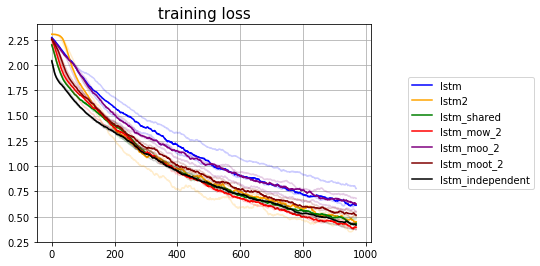

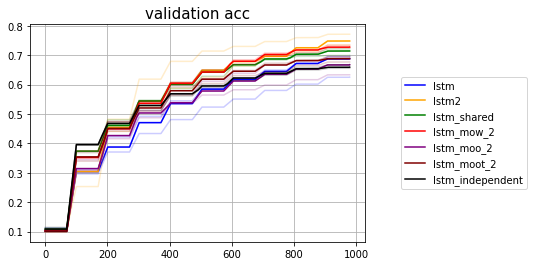

In [154]:
print('partial sum share: 8 steps, first 4 shared, last 4 shared')
for data_size in [1000,10000]:
    print('training size {}'.format(data_size))
    datadir = 'mo_models_2layers/partial_sum_share_{}/*/'.format(data_size)

    rnn_models = ['lstm.p*',
                  'lstm2.p*',
                  'lstm_shared.p*',
                  'lstm_mow_2.p*',
                  'lstm_moo_2.p*',
                  'lstm_moot_2.p*',
                  'lstm_independent.p*']
    rnn_models = [os.path.join(datadir, m) for m in rnn_models]

    plot_train_val_multiple(rnn_models) 

 14%|█▍        | 1/7 [00:00<00:01,  5.42it/s]

partial sum4: 5 steps, all shared
training size 1000


100%|██████████| 7/7 [00:01<00:00,  5.84it/s]


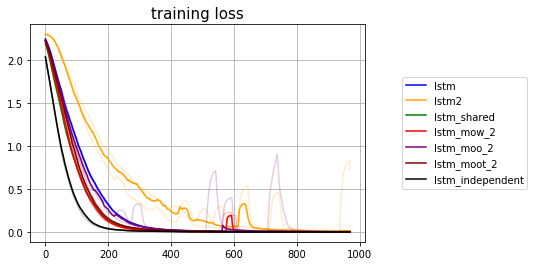

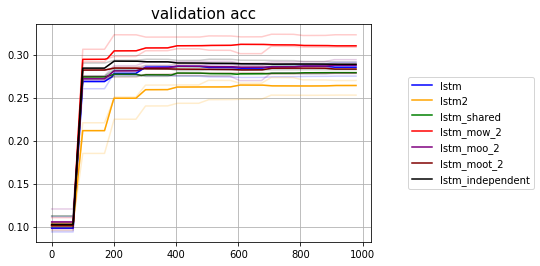

  0%|          | 0/7 [00:00<?, ?it/s]

training size 10000


100%|██████████| 7/7 [00:01<00:00,  5.27it/s]


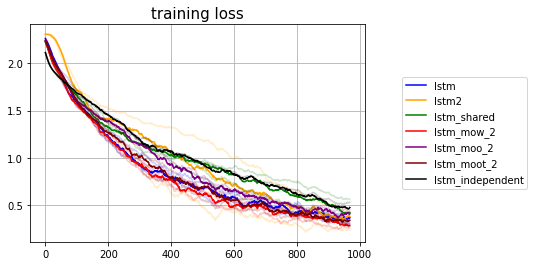

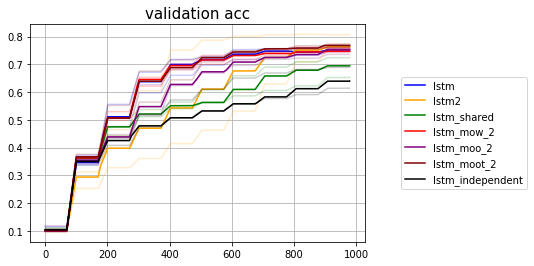

In [155]:
print('partial sum4: 5 steps, all shared')
for data_size in [1000,10000]:
    print('training size {}'.format(data_size))
    datadir = 'mo_models_2layers/partial_sum4_{}/*/'.format(data_size)

    rnn_models = ['lstm.p*',
                  'lstm2.p*',
                  'lstm_shared.p*',
                  'lstm_mow_2.p*',
                  'lstm_moo_2.p*',
                  'lstm_moot_2.p*',
                  'lstm_independent.p*']
    rnn_models = [os.path.join(datadir, m) for m in rnn_models]

    plot_train_val_multiple(rnn_models) 

 14%|█▍        | 1/7 [00:00<00:01,  5.85it/s]

diff task: 5 steps, all different
training size 1000


100%|██████████| 7/7 [00:00<00:00,  9.35it/s]


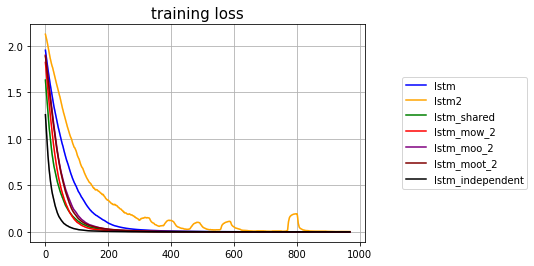

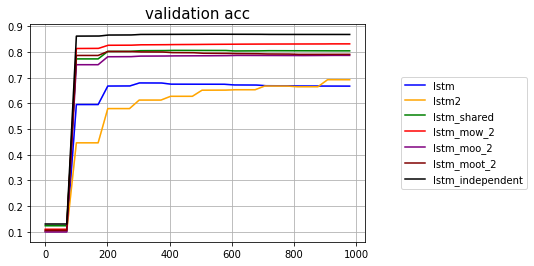

 14%|█▍        | 1/7 [00:00<00:00,  6.78it/s]

training size 10000


100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


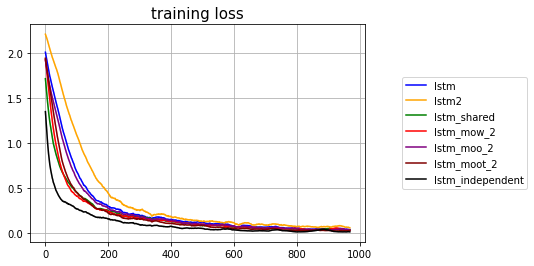

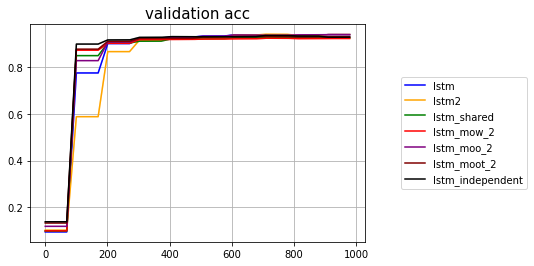

In [209]:
print('diff task: 5 steps, all different')
for data_size in [1000,10000]:
    print('training size {}'.format(data_size))
    datadir = 'mo_models_2layers/diff_task_{}/0/'.format(data_size)

    rnn_models = ['lstm.p*',
                  'lstm2.p*',
                  'lstm_shared.p*',
                  'lstm_mow_2.p*',
                  'lstm_moo_2.p*',
                  'lstm_moot_2.p*',
                  'lstm_independent.p*']
    rnn_models = [os.path.join(datadir, m) for m in rnn_models]

    plot_train_val_multiple(rnn_models) 

 14%|█▍        | 1/7 [00:00<00:00,  6.60it/s]

scarce: 1-9 steps, shared cycle of 3
training size 1000


100%|██████████| 7/7 [00:00<00:00,  7.17it/s]


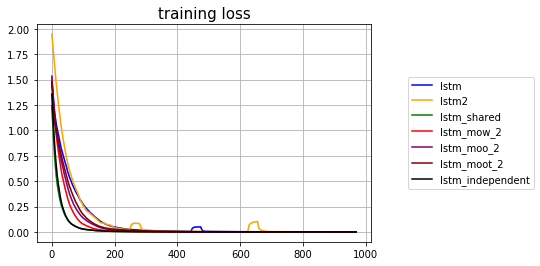

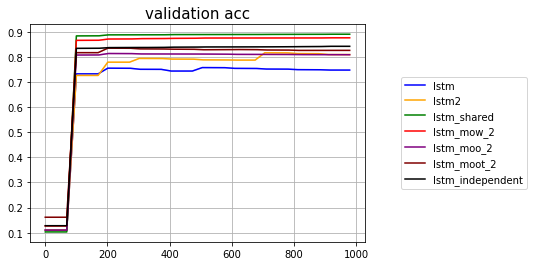

 14%|█▍        | 1/7 [00:00<00:00,  7.43it/s]

training size 10000


100%|██████████| 7/7 [00:00<00:00,  9.13it/s]


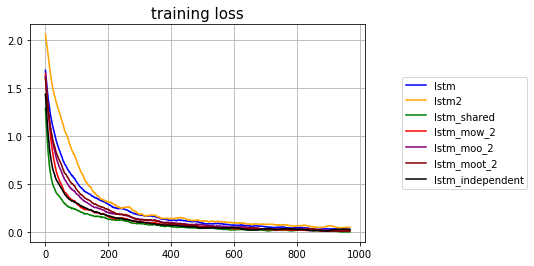

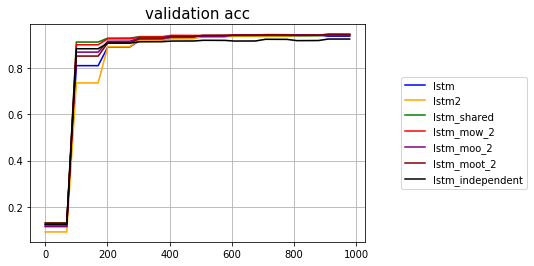

In [188]:
print('scarce: 1-9 steps, shared cycle of 3')
for data_size in [1000,10000]:
    print('training size {}'.format(data_size))
    datadir = 'mo_models_2layers/scarce_{}/*/'.format(data_size)

    rnn_models = ['lstm.p*',
                  'lstm2.p*',
                  'lstm_shared.p*',
                  'lstm_mow_2.p*',
                  'lstm_moo_2.p*',
                  'lstm_moot_2.p*',
                  'lstm_independent.p*']
    rnn_models = [os.path.join(datadir, m) for m in rnn_models]

    plot_train_val_multiple(rnn_models) 